In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
#import efficientnet.tfkeras as efn
from collections import Counter
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.style.use('ggplot')

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.keras.applications import DenseNet169

In [4]:
densenet169_conv = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in densenet169_conv.layers:
    layer.trainable = True

for layer in densenet169_conv.layers:
    print(layer, layer.trainable)

model = models.Sequential()

model.add(densenet169_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(13, activation='softmax'))

51888128/51877672 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f80f975cc50> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f80e05a3950> True
<keras.layers.convolutional.Conv2D object at 0x7f80f851ff90> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f80e054da90> True
<keras.layers.core.activation.Activation object at 0x7f80e04fa650> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f80f8770e10> True
<keras.layers.pooling.MaxPooling2D object at 0x7f80e044ffd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f80e0456950> True
<keras.layers.core.activation.Activation object at 0x7f80e045c250> True
<keras.layers.convolutional.Conv2D object at 0x7f80e0461950> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f80e046db50> True
<keras.layers.core.activation.Activation object at 0x7f80e0530b90> True
<keras.layers

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 512)               41746944  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [6]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001, rho=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

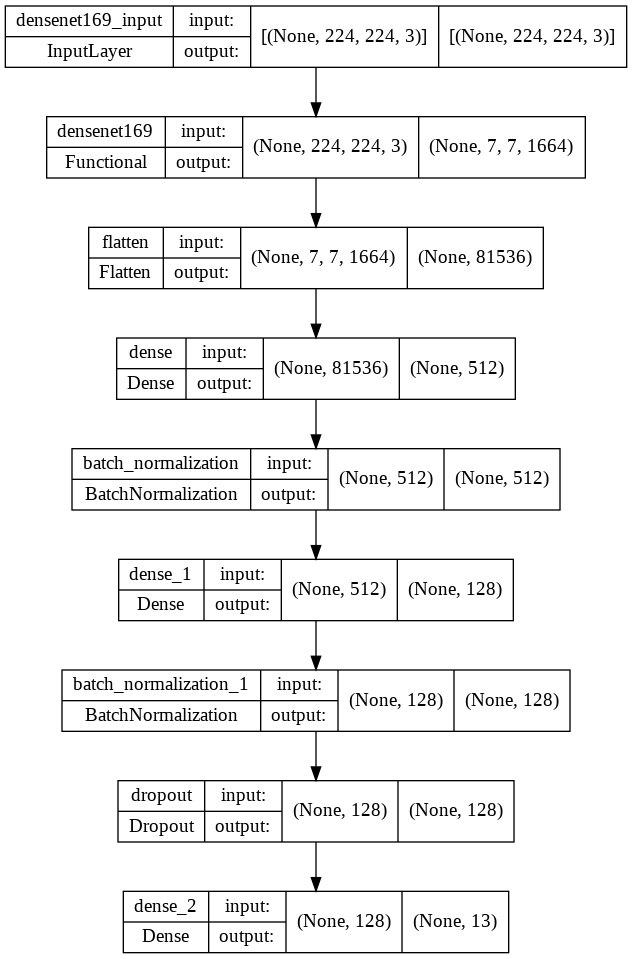

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [8]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/train/',
                                                 target_size = (224, 224),
                                                 shuffle=True)

Found 10590 images belonging to 13 classes.


In [11]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/val/',
                                            target_size = (224, 224), shuffle=False)

Found 1303 images belonging to 13 classes.


In [12]:
for cls, idx in training_set.class_indices.items():
    print('Class nr ',idx,' -> ', cls)

Class nr  0  ->  0Capri
Class nr  1  ->  10Pachy
Class nr  2  ->  12Phyll
Class nr  3  ->  14Macro
Class nr  4  ->  1Pnoep
Class nr  5  ->  2Malac
Class nr  6  ->  3Malac
Class nr  7  ->  4Anthi
Class nr  8  ->  5Anthr
Class nr  9  ->  6Corvu
Class nr  10  ->  7Dryoc
Class nr  11  ->  8Elanu
Class nr  12  ->  9Ortho


In [13]:
model_history = model.fit(training_set, batch_size=32, epochs=10, verbose=1, validation_data=(test_set))

Epoch 1/10
331/331 [==============================] - 4611s 14s/step - loss: 1.8279 - accuracy: 0.4785 - val_loss: 0.9781 - val_accuracy: 0.7022
Epoch 2/10
331/331 [==============================] - 175s 527ms/step - loss: 0.8876 - accuracy: 0.7316 - val_loss: 0.6623 - val_accuracy: 0.7936
Epoch 3/10
331/331 [==============================] - 175s 529ms/step - loss: 0.6313 - accuracy: 0.8128 - val_loss: 0.6035 - val_accuracy: 0.8219
Epoch 4/10
331/331 [==============================] - 175s 529ms/step - loss: 0.4771 - accuracy: 0.8582 - val_loss: 0.5336 - val_accuracy: 0.8358
Epoch 5/10
331/331 [==============================] - 175s 527ms/step - loss: 0.3860 - accuracy: 0.8845 - val_loss: 0.4746 - val_accuracy: 0.8550
Epoch 6/10
331/331 [==============================] - 175s 527ms/step - loss: 0.3281 - accuracy: 0.9038 - val_loss: 0.4641 - val_accuracy: 0.8588
Epoch 7/10
331/331 [==============================] - 174s 526ms/step - loss: 0.2689 - accuracy: 0.9212 - val_loss: 0.4288 - 

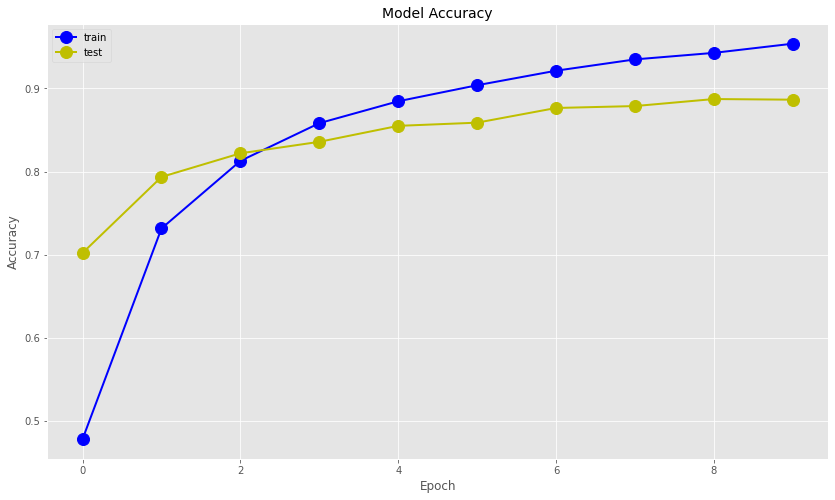

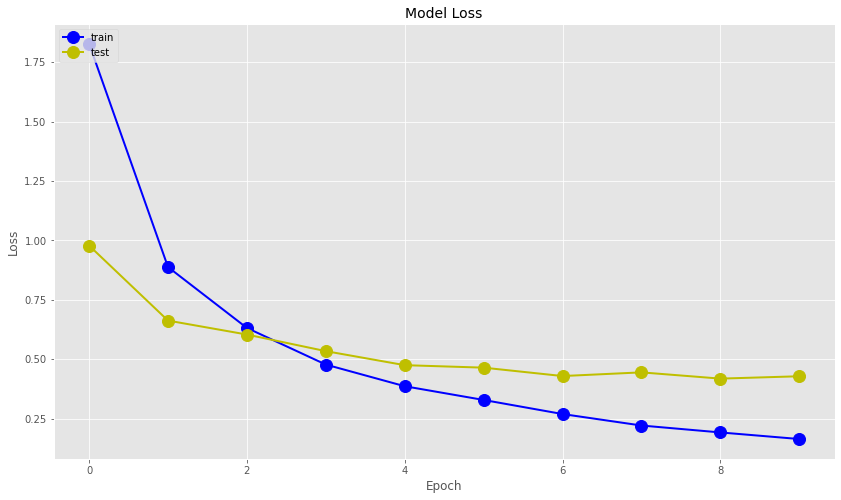

In [14]:
plt.figure(figsize=(14,8))
plt.plot(model_history.history['accuracy'], 'bo-', linewidth=2, markersize=12)
plt.plot(model_history.history['val_accuracy'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 # summarize history for loss
plt.figure(figsize=(14,8))
plt.plot(model_history.history['loss'], 'bo-', linewidth=2, markersize=12 )
plt.plot(model_history.history['val_loss'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
target_names = []
for key in training_set.class_indices:
  target_names.append(key)

print(target_names)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


41/41 [==============================] - 8s 189ms/step - loss: 0.4279 - accuracy: 0.8864
n Test_Accuracy:- 0.886415958404541
confusion matrix
[[ 70   6   0   0   0   1   0   0   0   0   1   2   0]
 [  0  46   1   0   0   2   2   0   0   0   1   1   1]
 [  0   1 270   0   2   0   0   0   0   1   0   2   1]
 [  0   2   3 170   0   0   0   2   0   0   0   4   2]
 [  0   0   2   3 136   5   0   1   0   0   0   0   1]
 [  0   7   0   0   0  52   0   0   0   1   0   1   1]
 [  0   4   4   7   0   3  51   5   0   2   3   0   1]
 [  0   0   1   0   2   0   0  35   0   0   0   2   0]
 [  1   1   1   1   0   0   4   1  34   2   1   2   0]
 [  0   1   6   8   0   0   1   0   0  55   0   0   0]
 [  0   0   0   1   0   0   0   0   6   2  47   1   1]
 [  0   0   3   1   0   0   0   0   0   0   0 134   0]
 [  0   4   1   3   0   0   1   0   0   0   0   0  55]]


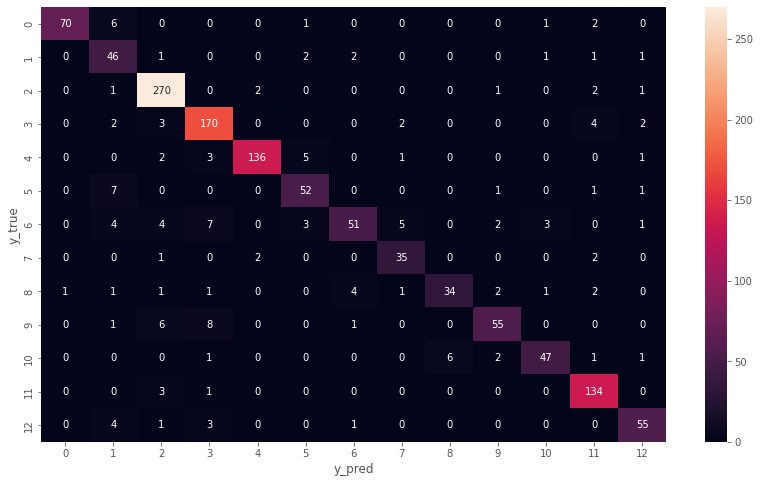

In [16]:
accuracy = model.evaluate(test_set)
print('n', 'Test_Accuracy:-', accuracy[1])
pred = model.predict(test_set)
y_pred = np.argmax(pred, axis=1)
#y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(test_set.classes, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(confusion_matrix(test_set.classes, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [17]:
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names ))

Classification Report
              precision    recall  f1-score   support

      0Capri       0.99      0.88      0.93        80
     10Pachy       0.64      0.85      0.73        54
     12Phyll       0.92      0.97      0.95       277
     14Macro       0.88      0.93      0.90       183
      1Pnoep       0.97      0.92      0.94       148
      2Malac       0.83      0.84      0.83        62
      3Malac       0.86      0.64      0.73        80
      4Anthi       0.80      0.88      0.83        40
      5Anthr       0.85      0.71      0.77        48
      6Corvu       0.87      0.77      0.82        71
      7Dryoc       0.89      0.81      0.85        58
      8Elanu       0.90      0.97      0.93       138
      9Ortho       0.87      0.86      0.87        64

    accuracy                           0.89      1303
   macro avg       0.87      0.85      0.85      1303
weighted avg       0.89      0.89      0.89      1303



In [18]:
target_names1 = []
for key in test_set.class_indices:
  target_names1.append(key)

print(target_names1)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


ROC AUC score: 0.9191715913897844


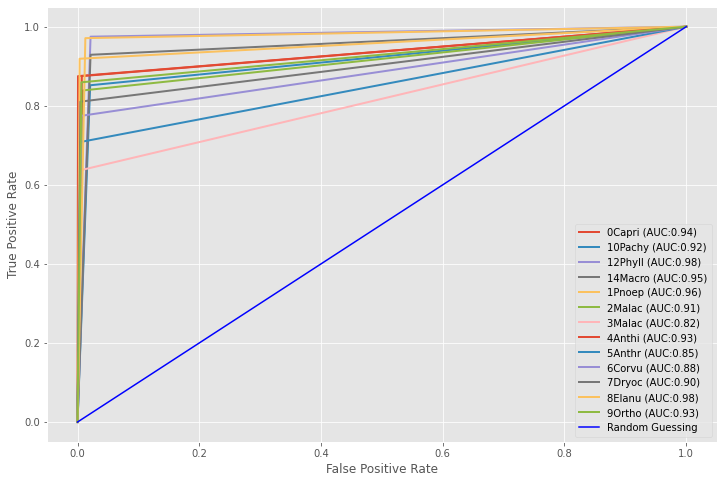

In [19]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_preds, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_preds = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names1):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_preds[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)),linewidth=2)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_preds, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_set.classes, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [20]:
top_k_accuracy_score(test_set.classes, pred, k=5)

0.9662317728319263

In [21]:
top_k_accuracy_score(test_set.classes, pred, k=5, normalize=False)

1259

In [22]:
top_k_accuracy_score(test_set.classes, pred, k=1)

0.886415963161934

In [23]:
top_k_accuracy_score(test_set.classes, pred, k=1, normalize=False)

1155

In [24]:
model.save('/content/drive/MyDrive/Birddata_split/m2_rmsprop_4.hdf5')

In [25]:
finalpreds = pd.DataFrame(y_pred)
#finalpreds.columns = sub_temp.columns
finalpreds.to_csv('/content/drive/MyDrive/Birddata_split/M2_rmsprop_4.csv',index=False)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
